In [1]:
test_data_paths = {
    "E. coli"     : "/home/tlp5359/data-UniRef/E-Coli/no-HP/E-Coli_UniRef100.fasta",
    "E. albertii" : "/home/tlp5359/data-UniRef/E-albertii/no-HP/E-albertii_208962_UniRef100.fasta",
    "E. fergusonii" : "/home/tlp5359/data-UniRef/E-fergusonii/no-HP/E-fergusonii_564_UniRef100.fasta",
    }
aa_replacements = {"U": "X", "Z": "X", "O": "X", "B": "X"}
translation_table = str.maketrans(aa_replacements)


# Precompute the sort order
lst = 'KCYDERHQNWSMFTVAILGPX'
all_subsets = [set("KCYM"),set("KCYMRHWST")] + [{aa} for aa in lst if aa != 'X']
sort_order = {char: index for index, char in enumerate(lst)}


In [2]:
from Bio import SeqIO
from collections import defaultdict, Counter
import statistics, time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

cov_results = {}
freq_results = {}
for name,in_file in test_data_paths.items():
    start_time = time.time()
    sequences =  [ (str(r.seq)) for r in SeqIO.parse(in_file, 'fasta')]
    print(f"Number of sequences from {name}'s testing dataset: {len(sequences):3,.0f}")
    merged_sequences = [ str(s).translate(translation_table) for s in sequences]

    # The set of all possible amino_acids
    joined_str = "".join(merged_sequences)
    all_chars = set(joined_str)
    print(f"There are {len(all_chars)} amino acids:",all_chars)
    
    # compute amino acids' frequencies
    token_counts = dict(sorted(Counter(joined_str).items(), key=lambda item: item[1], reverse=True))
    tot = sum(token_counts.values())
    freq = {k:v/tot for k,v in token_counts.items()}
    freq_results[name] = freq
    
    # Initialize a list to store the character counts for each string
    char_counts_list = []

    # Iterate through each string and count the occurrences of each character
    for s in merged_sequences:
        char_counts = defaultdict(int)
        for char in s:
            char_counts[char] += 1
        
        # Convert counts to percentages
        total_chars = len(s)
        char_percentages = {char: (char_counts[char] / total_chars) * 100 if total_chars > 0 else 0 for char in all_chars}
        
        # Append the percentage dictionary to the list
        char_counts_list.append(char_percentages)
    
    # Initialize dictionaries
    found_percentage = defaultdict(lambda: defaultdict(float))
    mean_coverage = defaultdict(float)
    std_coverage = defaultdict(float)
    f_range = [0] #, 10, 15, 25, 30, 35, 45]  # > x%

    # Precompute the sum of char counts for each subset
    coverage_per_seq_dict = {}
    for aa_set in all_subsets:
        sorted_aa_set = ''.join(sorted(aa_set, key=lambda char: sort_order.get(char, len(lst))))
        coverage_per_seq = [sum(s[aa] for aa in aa_set) for s in char_counts_list]
        coverage_per_seq_dict[sorted_aa_set] = coverage_per_seq

    # Calculate the found percentages, mean, and standard deviation
    for k, coverage_per_seq in coverage_per_seq_dict.items():
        total_seqs = len(coverage_per_seq)
        for i in f_range:
            found_percentage[k][i] = sum(1 for s in coverage_per_seq if s > i) * 100 / total_seqs
        found_percentage[k][100] = sum(1 for s in coverage_per_seq if s == 100) * 100 / total_seqs
        mean_coverage[k] = statistics.mean(coverage_per_seq)
        std_coverage[k] = statistics.stdev(coverage_per_seq)
    
    # Convert dictionaries to DataFrames
    df1 = pd.DataFrame(found_percentage).T
    df1.columns = [ f'%%found >{i}%' for i in f_range+[100]]
    df2 = pd.DataFrame.from_dict(mean_coverage, orient='index', columns=['%%coverage'])
    df3 = pd.DataFrame.from_dict(std_coverage, orient='index', columns=['std(%%coverage)'])

    # Concatenate DataFrames along columns
    df = pd.concat([df1, df2, df3], axis=1)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'set'}, inplace=True)
    df['set size'] = df['set'].apply(lambda x: len(x.strip()))
    cov_results[name] = df
    df1,df2, df3, df = None, None, None, None
    print("finished (sec): ", time.time() - start_time)


Number of sequences from E. coli's testing dataset: 3,516,528
There are 21 amino acids: {'Q', 'M', 'I', 'N', 'A', 'G', 'E', 'X', 'Y', 'L', 'W', 'D', 'F', 'T', 'K', 'S', 'H', 'V', 'R', 'P', 'C'}
finished (sec):  577.1316957473755
Number of sequences from E. albertii's testing dataset: 105,677
There are 21 amino acids: {'Q', 'M', 'I', 'N', 'A', 'G', 'E', 'X', 'Y', 'L', 'W', 'D', 'F', 'T', 'K', 'S', 'H', 'V', 'R', 'P', 'C'}
finished (sec):  19.159886837005615
Number of sequences from E. fergusonii's testing dataset: 57,790
There are 21 amino acids: {'Q', 'M', 'I', 'N', 'A', 'G', 'E', 'X', 'Y', 'L', 'W', 'D', 'F', 'T', 'K', 'S', 'H', 'V', 'R', 'P', 'C'}
finished (sec):  9.860452890396118


In [9]:
cov_results["E. coli"]

,set,%%found >0%,%%found >100%,%%coverage,std(%%coverage),set size
0,KCYM,99.996246,0.000000,11.483336,3.169877,4
1,KCYRHWSMT,99.999943,0.000000,32.844052,4.303069,9
2,K,99.392412,0.000000,4.594360,2.210734,1
3,C,87.596487,0.000000,1.241900,1.096423,1
4,Y,98.156790,0.000000,2.951485,1.468464,1
5,D,99.474994,0.000000,5.209103,1.863237,1
6,E,99.567613,0.000000,5.760686,2.292004,1
7,R,99.690007,0.000000,5.732599,2.322309,1
8,H,96.701661,0.000000,2.220866,1.284501,1
9,Q,99.290095,0.000000,4.461912,1.908286,1


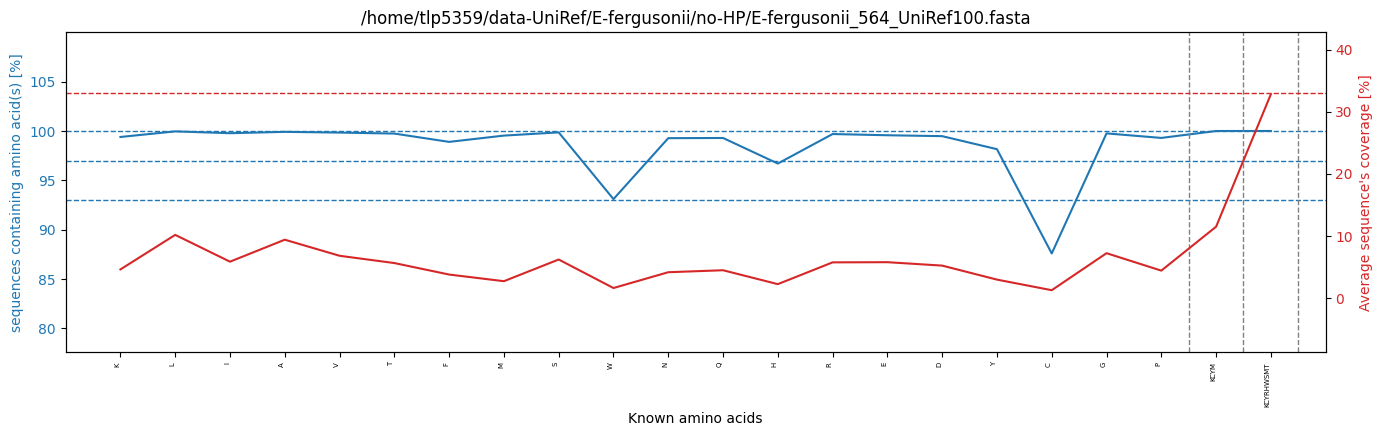

In [3]:
for name, df in cov_results.items():
    r = [1,4,9]
    plot_df = df[(df['set size'].isin(r))].sort_values(by='set', key=lambda col: col.map(lambda word: [sort_order.get(char, len(lst)) for char in word])).sort_values(by='set size')

    x_lines =  plot_df['set size'].value_counts().sort_index().cumsum().reset_index()['count'] 

    fig, ax1 = plt.subplots(figsize=(14, 4))  # Adjust the figure size as needed

    # Plot the first line on the first y-axis
    color = 'tab:blue'
    ax1.set_ylabel('sequences containing amino acid(s) [%]', color=color)
    yy = plot_df['%%found >0%']

    ax1.plot(plot_df['set'], yy, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlim(-1,len(plot_df))
    ax1.set_ylim(yy.min()-10, yy.max()+10)
    ax1.set_xticks(ticks = np.arange(len(plot_df)), labels = plot_df['set'], rotation=90, ha='right', fontsize = 5)
    # ax1.set_xticks(ticks = np.arange(len(plot_df)), labels = plot_df['set'].apply(len), rotation=90, ha='right', fontsize = 5)
    # ax1.set_xticks(ticks = x_lines, labels = [list(plot_df['set'])[i] for i in x_lines], rotation=45, ha='right')
    ax1.set_xlabel("Known amino acids")

    for y in [93,97,100]:
        ax1.axhline(y=y, color=color, linestyle='--', linewidth=1)
    for x in x_lines:
        ax1.axvline(x=x-0.5, color='gray', linestyle='--', linewidth=1)

    # Create a second y-axis that shares the same x-axis
    ax2 = ax1.twinx()

    # Plot the second line on the second y-axis
    color = 'tab:red'
    ax2.set_ylabel('Average sequence\'s coverage [%]', color=color)
    yyy = plot_df['%%coverage']
    ax2.plot(plot_df['set'],yyy, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(yyy.min()-10, yyy.max()+10)
    for y in [33,50]:
        ax2.axhline(y=y, color=color, linestyle='--', linewidth=1)



    # ax2.plot(plot_df['set'], plot_df['%%no_mask'], color='tab:orange')
    plt.title(in_file)
    plt.tight_layout()
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15)
    plt.show()
    break

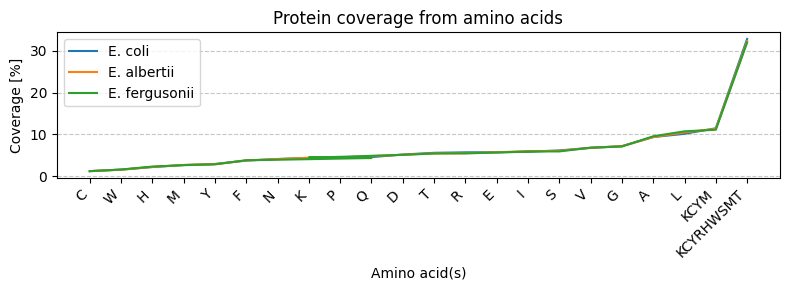

In [4]:
# # AMINO ACIDS FREQUENCIES

# # visualize

# fig,axes = plt.subplots(1,1,figsize=(8,3))


# for name, df in cov_results.items():
#   plot_df = df.sort_values(by='%%coverage')
#   axes.plot(plot_df['set'], plot_df['%%coverage'], label=name)

#   # Set labels and title
#   axes.set_xlabel('Amino acid(s)')
#   axes.set_ylabel('Coverage [%]')
#   axes.set_title(f'Protein coverage from amino acids')


# axes.set_xticks(ticks = np.arange(len(plot_df)), labels = plot_df['set'], rotation=45, ha='right')
# axes.legend()
# axes.grid(True, axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.savefig("data1.jpeg", dpi=150)
# plt.show()


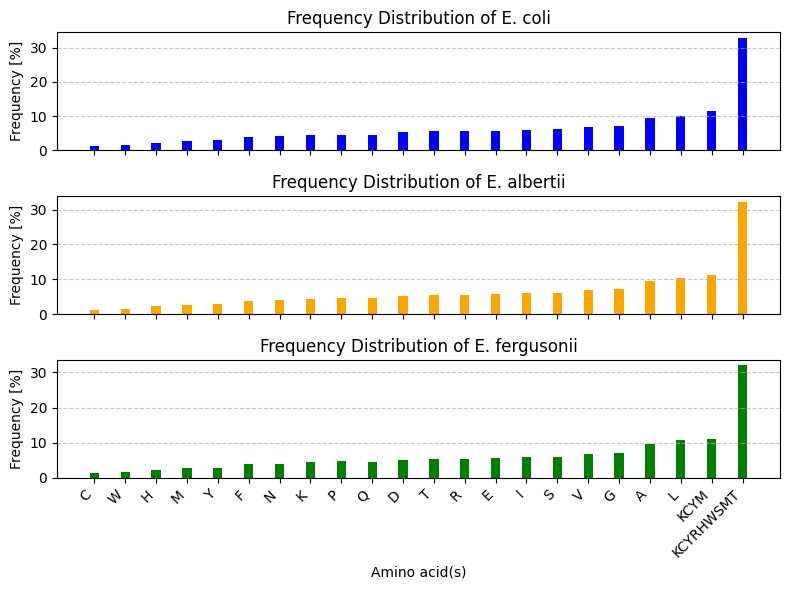

In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
colors = ['blue', 'orange', 'green']
c = 0

for name, df in cov_results.items():
    plot_df = df.sort_values(by='%%coverage')
    axes[c].bar(plot_df['set'], plot_df['%%coverage'], color=colors[c], width=0.3)
    
    # Set labels and title
    axes[c].set_ylabel('Frequency [%]')
    axes[c].set_title(f'Frequency Distribution of {name}')
    axes[c].grid(True, axis='y', linestyle='--', alpha=0.7)
    c += 1

# Set x-axis labels and ticks on the last subplot
axes[c-1].set_xlabel('Amino acid(s)')
axes[c-1].set_xticks(np.arange(len(plot_df)))
axes[c-1].set_xticklabels(plot_df['set'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [ ]:
# # AMINO ACIDS FREQUENCIES

# # visualize

# fig,axes = plt.subplots(3,1,figsize=(8,6))
# colors=['blue','orange','green']
# c=0

# for name,freq in freq_results.items():
#   freq = dict(reversed(list(freq.items())))
#   axes[c].bar(range(len(freq)),freq.values(), color=colors[c], width=0.2)

#   # Set labels and title
#   axes[c].set_xlabel('Amino acid')
#   axes[c].set_ylabel('Frequency')
#   axes[c].set_title(f"Frequency distribution of {name}")
#   axes[c].set_xticks(range(len(freq)),freq.keys())
#   axes[c].grid(True, axis='y', linestyle='--', alpha=0.7)
#   c+=1

# plt.tight_layout()
# plt.savefig("data2.jpeg", dpi=150)
# plt.show()
